# Chapter 2 - Perceptrons 

In [1]:
%run Datasets.ipynb
%run Plot\ Utilities.ipynb
%run Chapter\ 2\ Utilities.ipynb
%run Animations.ipynb
import numpy as np
import json
import math

The last chapter introduced a framework for thinking about supervised machine learning and explored a toy binary classification algorithm that found a threshold to apply to a single feature.  It did that by exhaustively exploring the space of candidate thresholds and choosing the one that maximized accuracy on the training data.  This chapter describes the Perceptron Learning Algorithm, which is significanty better along a number of dimensions.  Perceptrons consider the values of all features when making a classification decision instead of just one.  For example, to know if a suitcase will fit into the overhead bin on a plane, I need to know it's height, width, _and_ length.  Rather than exhaustively exploring a large or even intracable number of candidate functions $f$, the Perceptron Learning Algorithm iteratively updates a single candidate driven by the goal of reducing the number of errors on the training set.  Finally, the algorithm is well-motivated theoretically and admits to easy geometric interpretation.  We'll start with the latter to get an intuitive understanding of Perceptrons and end with former to see how the algorithm can be derived from first principles.

The term "Perceptron" refers to the functional form for a classifier.  The term "Perceptron Learning Algorithm" refers to the algorithm for searching over the space of possible Perceptrons to find a good one.  The text below may sometimes use the term Perceptron to refer to both the representation and the learning algorithm when the meaning is clear from the context.

## 2.1 Weights and Hyperplanes

Before going any further, it will help to tighten up the notation a bit.  Bold lower case letters, like ${\bf u}$ and ${\bf v}$, will denote vectors of real numbers.  In a departure from the first chapter, $f$ will denote the true function that assigns class labels and $\hat f$ will denote a learned approximation to $f$.  Likewise, $y$ will be the true label associated with feature vector ${\bf x}$, i.e., $f({\bf x}) = y$, and $\hat y$ will be the prediction made by $\hat f$ for ${\bf x}$, i.e., $\hat f({\bf x}) = \hat y$.  

Using this notation, a training set contains $({\bf x}, f({\bf x}))$ pairs.  A supervised learning algorithm, like the Perceptron, uses the training set to find a function $\hat f$ such that $\hat f({\bf x}) =  f({\bf x})$ for instances not in the training set.  Think of $f$ as the function computed by Mother Nature to assign class labels, and $\hat f$ as an attempt to figure out what Mother Nature is doing.

Rather than representing possible class labels as a set of two tokens, like ${\tt \{poisonous, edible\}}$, it is often mathematically expedient to represent the two class labels as belonging to either ${\tt \{-1, +1\}}$ or ${\tt \{0, 1\}}$.  The Perceptron assumes $y \in {\tt \{-1, +1\}}$ to make the algorithm and math simpler. Given a feature vector ${\bf x}$ with $n$ elements, the Perceptron Learning Algorithm seeks a **weight vector** ${\bf w}$ containing $n$ real numbers such that the following is true for all training instances $({\bf x}, y)$:

$${\tt sign}({\bf w} \cdot {\bf x}) = y$$ 

Recall that ${\bf w} \cdot {\bf x}$, the dot product, is just the sum of the products of the corresponding elements of ${\bf w}$ and ${\bf x}$:

$${\bf w} \cdot {\bf x} = \sum_{i=1}^n w_i x_i$$

Given a weight vector ${\bf w}$ and an attribute vector ${\bf x}$, the Perceptron computes a weighted sum of feature values and predicts class ${\tt -1}$ if that sum is negative and class ${\tt +1}$ if that sum is positive.  That is:

$$\hat f({\bf x}) = {\tt sign}({\bf w} \cdot {\bf x})$$

Weight vectors are common in machine learning.  Given a training set, many machine learning algorithms produce a weight vector that is used in some way to classify new instances, and the goal of the algorithm is to find "good" weights.  For example, a good weight vector might be one that classifies all of the training data correctly.  Consider the two mushroom instances shown below from Chapter 1.

In [2]:
training_set = json.loads(open('chapter_1_mushroom_dataset.json').read())
df = pd.DataFrame(training_set[:2])
df = df[['color', 'width', 'height', 'label']]
df

,color,width,height,label
0,-0.311688,0.358501,0.936567,edible
1,-0.472327,0.817906,0.468387,poisonous


Recall that short, wide mushrooms are poisonous; tall, thin mushrooms are edible; and the color attribute is irrelevant.  For this dataset, the weight vector will contain three elements, one for each of the features.  Let $w_c$ be the weight associated with color, $w_w$ be the weight associated with width, and $w_h$ be the weight associated with height.  The class label assigned to a mushroom is thus:

$${\tt sign}(w_c * {\tt color} + w_w * {\tt width} + w_h * {\tt height})$$

Because the ${\tt sign()}$ function returns either ${\tt -1}$ or ${\tt +1}$, we need to map the original class labels, i.e., ${\tt poisonous}$ and ${\tt edible}$, to those values.  Suppose that ${\tt poisonous}$ is mapped to ${\tt +1}$ and ${\tt edible}$ is mapped to ${\tt -1}$.  What weights might work for the two instances above?

Setting $w_c = 0$ effectively ignores the value of the ${\tt color}$ attribute, which is good because it is irrelevent.  No matter the value of  ${\tt color}$, it is the case that $w_c * {\tt color} = 0$ and therefore the mushroom's color has no impact of ${\bf w} \cdot {\bf x}$.  We want ${\bf w} \cdot {\bf x} > 0$ for poisonous mushrooms because they are the positive class.  Poisonous mushrooms are short and wide.  If $w_w > 0$ then the wider a mushroom is the larger the value of $w_w * {\tt width}$ and the larger the value of ${\bf w} \cdot {\bf x}$.  But we need to rule out any mushrooms that are tall.  Setting $w_h < 0$ does that, because as mushrooms grow taller, the value of $w_h * {\tt height}$ grows more negative, pulling ${\bf w} \cdot {\bf x}$ in that direction.  Note that this seems to work for edible musrooms as well because they are tall, making $w_h * {\tt height}$ a large negative number, and narrow, making $w_w * {\tt width}$ a small positive number.  The net effect is that the weighted sum of feature values for edible mushrooms should be negative.

Putting all of this together, suppose ${\bf w} = [w_c, w_w, w_h] = [0, 1, -1]$.  The value of ${\tt sign}({\bf w} \cdot {\bf x})$ for the first instance above is:

$${\tt sign}(0 * -0.311688 + 1 * 0.358501 -1 * 0.936567) = {\tt sign}(-0.578066) = -1$$

Therefore, the first mushroom is assigned class label ${\tt -1}$ which corresponds to ${\tt edible}$, which is correct.  The value of ${\tt sign}({\bf w} \cdot {\bf x})$ for the second instance above is:

$${\tt sign}(0 * -0.472327 + 1 * 0.817906 -1 * 0.468387) = {\tt sign}(0.349519) = +1$$

The second mushroom is also classified correctly as belonging to class ${\tt +1}$, which corresponds to ${\tt poisonous}$.  The Perceptron Learning Algorithm automatically and efficiently finds weight vectors that correctly classify the training data, even for datasets with many features and many instances that are impossible to find by hand as we did above.

What does the separator found by the Perceptron look like geometrically?  If $y = {\tt +1}$ when ${\tt sign}({\bf w} \cdot {\bf x}) > 0$ and $y = {\tt -1}$ when ${\tt sign}({\bf w} \cdot {\bf x}) < 0$, then when ${\bf w} \cdot {\bf x} = 0$ the point ${\bf x}$ is on the boundary between the two classes.  Consider the dataset below where each instance has two numeric features, $x_1$ and $x_2$, and class labels in ${\tt \{-1, +1\}}$.

In [3]:
df = perceptron_dataset()
df

,x1,x2,y
0,-0.538452,-0.111913,-1
1,0.432105,-1.214330,-1
2,-0.151847,0.187288,-1
3,-0.328395,0.095405,-1
4,0.805103,0.139580,-1
5,0.401920,0.581856,-1
6,-1.340469,0.175839,-1
7,1.582838,-0.005531,-1
8,-0.713039,-1.215321,-1
9,0.391271,1.559468,-1


Because there are two features, the weight vector will have two weights, i.e., ${\bf w} = [w_1, w_2]$, so the boundary between the two classes consists of all points for which:

$${\bf w} \cdot {\bf x} = w_1 x_1 + w_2 x_2 = 0$$

The dataset is plotted below in the 2-dimensional feature space, with the standard red circles and green plusses to denote points belonging to the two different classes.  Solving the equality above for $x_2$ yields the following, which is the equation for a line in the feature space:

$$x_2 = -\frac{w_1}{w_2} x_1$$

The slope of this line is ${-w_1/w_2}$, and because the equation has no constant term it must pass through the origin.  (We'll remove that limitation shortly.) That is, the weight vector in a 2-D feature space defines a line that cuts the plane in half.  Every point ${\bf x}$ on one side of the line will yield ${\bf w} \cdot {\bf x} > 0$ and thus be classified as a positive instance ($y = {\tt +1}$).  Every point on the other side of the line will will yield ${\bf w} \cdot {\bf x} < 0$ and thus be classified as a negative instance ($y = {\tt -1}$).

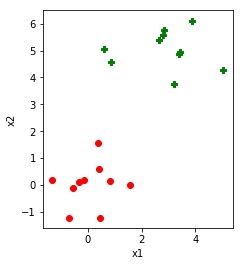

In [4]:
plot_2d(df)

The cell below generates a plot of the dataset above, and take as input a 2-D weight vector.  The black line, which corresponds to all points ${\bf x}$ for which ${\bf w} \cdot {\bf x} = 0$, is called a **separator**, or **linear separator**, or **separating hyperplane**.  That's because the line is meant to separate the points that belong to one class from those that belong to the other.  It's also a line, and thus the separator is linear.  Note that in one dimension, as we saw in the first chapter, a separator can be a point on the real line. To the left of that point is one class, and to the right is the other. As shown analytically above and graphically below, a linear separator in two dimensions is a line.    A linear separator in three dimensions is a plane.  Every point in the 3-D feature space on one side of the plane is a positive instance, and every point on the other side is a negative instance.  More generally, for $n > 3$ features or dimensions the weight vector defines a separating _hyperplane_.

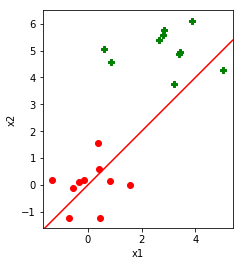

In [5]:
plot_2d(df, weights = [1, -1], show_separator = True)

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

Try a few different values for the weight vector.  In particular, for any given set of weights, e.g., ${\bf w} = [2, 1]$, try the negative of those weights, i.e., ${\bf w} = [-2, -1]$.  What you'll find is that you get exactly the same separating hyperplane plotted in the feature space.  The line may be the same, but the difference is which side of the line is the positive half of the plane and which is the negative half.  Before exploring that topic, let's clean up one more loose end.

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

Recall that weight vectors of the form ${\bf w} = [w_1, w_2]$ yield separators that pass through the origin because there is no constant or bias term.  Adding a constant term so that separators can move off of the origin is typically required and handled in one of two ways.  The first is to declare that the algorithm is looking for two things, a weight vector of $n$ real numbers (i.e., ${\bf w} \in \mathbb{R}^n$) and a bias term $b \in \mathbb{R}$, and that:

$$\hat f({\bf x}) = {\tt sign}({\bf w} \cdot {\bf x} + b)$$

The other is to augment each ${\bf x}$ vector with another element, $x_0$, that is always set to 1.  The corresponding weight is $w_0$, so the dot product winds up with a constant term $w_0$ that plays the role of the bias:

$${\bf w} \cdot {\bf x} = \sum_{i=0}^n w_i x_i =
w_0 x_0 + \sum_{i=1}^n w_i x_i = w_0 + \sum_{i=1}^n w_i x_i$$

Note that the starting index on the first sum is 0 and changes to 1 for the last two sums.  We'll use this formulation as it tends to make the math a bit cleaner.

OK, so which side of the separating hyperplane is the positive side and which is the negative side?  It turns out that (1) the weight vector is perpendicular to the separating hyperplane and (2) it points in the direction of the positive side.  To prove these two statements, it will help to recall that two vectors are perpendicular or orthogonal if their dot product is zero, i.e., ${\bf u} \cdot {\bf v} = 0$.

**Proposition 1:** For ${\bf w} \in \mathbb{R}^n$, ${\bf w}$ is orthogonal to the hyperplane defined by ${\bf w} \cdot {\bf x} = 0$.

**Proof:** Let ${\bf u}$ and ${\bf v}$ be points on the hyperplane defined by ${\bf w} \cdot {\bf x} = 0$.  Then ${\bf u} - {\bf v}$ is a vector that is parallel to the hyperplane.  Because ${\bf w} \cdot ({\bf u} - {\bf v}) = {\bf w} \cdot {\bf u} - {\bf w} \cdot {\bf v} = 0 - 0 = 0$, it is the case that ${\bf w}$ is perpendicular to ${\bf u} - {\bf v}$ and thus to the hyperplane as well.
<font size="5">&#8718;</font>

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

The cell below shows the idea behind Proposition 1 visually.  The sole argument to the `Proposition_1` function is a weight vector of the form $[w_0, w_1, w_2]$. It then plots five things:

* The hyperplane corresponding to ${\bf w}$ is drawn in black.
* Two vectors on the hyperplane, ${\bf u}$ and ${\bf v}$, are drawn in blue.  Their locations on the hyperplane are chosen at random.
* The vector ${\bf u} - {\bf v}$ is drawn in red.  Note that it starts at the origin and is parallel to the hyperplane, as expected.
* The weight vector less the constant term, i.e., $[w_1, w_2]$, is also drawn in the red.  It is perpendicular to both the hyperplane and ${\bf u} - {\bf v}$, as expected.

The values of ${\bf u}$, ${\bf v}$, ${\bf u} - {\bf v}$, and ${\bf w}$ are  printed below the plot.

You can run the cell multiple times to see different choices for ${\bf u}$ and ${\bf v}$.  Also try different values for the weight vector.  Because ${\bf u} - {\bf v}$ and ${\bf w}$ are drawn  from the origin, it helps visually to make $w_0$ non-zero, otherwise it's hard to see ${\bf u}$ and ${\bf v}$.

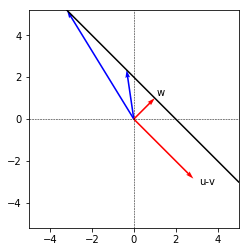

     u = (-0.34, 2.34)
     v = (-3.18, 5.18)
 v - u = (2.84, -2.84)
     w = (1.00, 1.00)


In [6]:
Proposition_1([-2, 1, 1])

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

The length of vector ${\bf u}$ is denoted $||{\bf u}||_2$ and is called the Euclidean norm or L2 norm. It is the square root of the sum of the squares of the elements of ${\bf u}$, i.e., $||{\bf u}||_2 = \sqrt{\sum_i u_i^2}$.  That quantity appears in the proof of Proposition 2 below.

**Proposition 2:** For ${\bf w} \in \mathbb{R}^n$, ${\bf w}$ points in the direction of the positive half hypercube defined by ${\tt sign}({\bf w} \cdot {\bf x})$. 

**Proof:** Let ${\bf u}$ be any point on the hyperplane defined by ${\bf w}$.  The point ${\bf u} + \lambda {\bf w}$ for $\lambda > 0$ is obtained by starting at ${\bf u}$ and moving some distance (i.e., $\lambda ||w||_2$) in the direction of ${\bf w}$.  Note that:

$$
\begin{eqnarray}
{\bf w} \cdot ({\bf u} + \lambda {\bf w}) 
  & = & {\bf w} \cdot {\bf u} + \lambda {\bf w} \cdot {\bf w} \\
  & = & 0 + \lambda \sum_{i}^n w_i^2 \\
  & > & 0
\end{eqnarray}
$$

Therefore, ${\bf w}$ points in the direction of the positive half hypercube defined by ${\tt sign}({\bf w} \cdot {\bf x})$.
<font size="5">&#8718;</font>

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

The cell below shows the idea behind Proposition 2 visually. The `Proposition_2` function takes a weight vector of the form $[w_0, w_1, w_2]$. It plots the corresponding hyperplane in black and plots a randomly selected point, ${\bf u}$, on the hyperplane in blue.  It then chooses a random value for $\lambda > 0$ and plots the location of ${\bf u} + \lambda {\bf w}$ in green and connects the two points with the vector $\lambda {\bf w}$.  Below that you'll see the values of ${\bf u}$, $\lambda$, and ${\bf w} \cdot ({\bf u} + \lambda {\bf w})$ which should be greater than zero. 

Run the cell several times.  You'll notice that points farther away from the hyperplane, i.e., with larger values of $\lambda$, have larger values of ${\bf w} \cdot ({\bf u} + \lambda {\bf w})$.  The `Proposition_2` function takes an optional second argument, which is the value of $\lambda$.  Using $\lambda = 0$ will leave the point on the hyperplane and should result in the dot product being zero.  Using $\lambda < 0$ will move away from the hyperplane in the _opposite_ direction of ${\bf w}$ to the negative half of the plane, and should result in a dot product that is negative and an arrow that is red.  Said differently, ${\bf -w}$ points in the direction of the negative half hypercube defined by ${\tt sign}({\bf w} \cdot {\bf x})$.

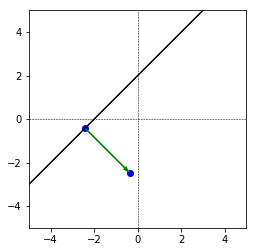

u = (-2.42, -0.42)
lambda = 2.06
w . (u + lambda * w) = 4.13


In [7]:
Proposition_2([2, 1, -1])

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

## 2.2 The Learning Algorithm

The Perceptron Learning Algorithm starts with an initial weight vector that contains all zeroes, so ${\bf w} \cdot {\bf x} = 0$ for all points in the feature space because the classifier has not yet seen any training data.  It then makes a series of passes over the training set.  Each pass is called an **epoch**, and involves using the the current weight vector to classify each of the training instances in turn.  If ${\tt sign}({\bf w} \cdot {\bf x}) = y$ for a training instance, the classifier is correct for that instance and nothing happens.  If ${\tt sign}({\bf w} \cdot {\bf x}) \neq y$ for a training instance, the classifier is wrong for that instance and the weight vector is modified.  The algorithm terminates when the weight vector was not updated during an epoch (i.e., it classified all of the training instances correctly) or a maximum number of epochs has been reached.

A simple implementation of the Perceptron Learning Algorithm is shown below.  Its arguments are as follows:
* **df** is a dataframe containing the training set, one instance per row.  All columns except the one with the class label are assumed to correspond to features.
* **label** is the name of the column containing the class label, whose values are assumed to be in ${\tt \{-1, +1\}}$.
* **epochs** is the maximum number of complete passes through the training set.
* **bias** controls whether a column of 1's ($x_0$) will be added to the dataframe.  If the dataframe already has such a column, or if it is desirable to force the hyperplane to pass through the origin, set bias to be false.

In [46]:
def perceptron(df, label = 'y', epochs = 100, bias = True):
    
    if bias:
        df = df.copy()
        df.insert(0, '_x0_', 1)
        
    w = np.zeros(len(df.columns) - 1)
    features = [column for column in df.columns if column != label]

    for _ in range(epochs):
        errors = 0
        for _, row in df.iterrows():
            x = row[features]
            y = row[label]
            if y * np.dot(w, x) <= 0:
                w = w + y * x
                errors += 1
            yield w.copy()
        if errors == 0:
            break

**Hint:** If you don't see line numbers in the cell above, try clicking in it and typing ${\tt <ESC>}$ and then ${\tt L}$.

The interesting part of the algorithm from a learning perspective is lines ${\bf 15 - 16}$, but we'll start at the top.  Lines ${\bf 3 - 5}$ add a new column filled with 1's to the dataframe if a constant term is needed in the weight vector.  Line ${\bf 7}$ initializes the weight vector to all zeroes, and line ${\bf 8}$ gets the names of the columns containing feature values.  Next there are two nested loops.  Each iteration of the outer loop represents an epoch, a complete pass over the data.  Each iteration of the inner loop considers one training instance (row in the dataframe).  Lines ${\bf 13}$ and ${\bf 14}$ get the values of ${\bf x}$ and $y$ for the current instance, respectively.  Lines ${\bf 11}$, ${\bf 17}$, ${\bf 19}$, and ${\bf 20}$ keep track of the number of misclassified instances during each epoch and stop if an epoch is completed with no errors.  Line ${\bf 18}$ ensures that the output of the algorithm is a Python generator that contains the sequence of weight vectors explored.  If there are $n$ rows in the dataframe and the algorithm runs for $e$ epochs, the generator will contain $n*e$ items.  The last of these weight vectors is the one that should be used to classify test instances, but the others are useful when animating the behavior of the algorithm below.

Line ${\bf 15}$ asks whether $y * {\bf w} \cdot {\bf x} \leq 0$.  If so, that instance is misclassified.  Why?  Let's assume that the misclassified instance is a positive one, i.e., $y = {\tt +1}$.  If $y * {\bf w} \cdot {\bf x} < 0$ then ${\bf w} \cdot {\bf x}$ must be less than zero because $y = {\tt +1}$.  In that case, ${\tt sign}({\bf w} \cdot {\bf x}) = -1$ and the predicted class label is not the same as the true class label.  Likewise, if $y = {\tt -1}$ and $y * {\bf w} \cdot {\bf x} < 0$, then ${\bf w} \cdot {\bf x}$ must be greater than zero.  In that case the instance is misclassified as well because ${\tt sign}({\bf w} \cdot {\bf x}) = {\tt +1}$ and the true class label is ${\tt -1}$.  Alternatively, if the signs of $y$ and ${\bf w} \cdot {\bf x}$ are the same, either both ${\tt +1}$ or ${\tt -1}$, the instance is classified correctly and the product $y * {\bf w} \cdot {\bf x}$ is positive.  The inequality in line **15** is $\leq$ rather than $<$ to catch the initial condition in which the weight vector is all zeroes and ${\bf w} \cdot {\bf x} = 0$ regardless of the value of ${\bf x}$.

Line ${\bf 16}$ is the weight update, or where the learning actually happens.  All it does is add $y * {\bf x}$ to the weight vector, which only happens when the corresponding instance is misclassified by the current weight vector.  If the misclassified instance is a positive one, the weight update is ${\bf w} = {\bf w} + {\bf x}$.  If the misclassified instance is a negative one, the weight update is ${\bf w} = {\bf w} - {\bf x}$.  

There are two ways to think about what the weight update is doing.  The first is analytically.  If a _positive instance_ is misclassified, then ${\bf w} \cdot {\bf x} < 0$.  The weights need to be changed so that this dot product is increased and eventually becomes positive for that instance.  If ${\bf w}$ is the weight vector before the update and ${\bf w} + y * {\bf x} = {\bf w} + {\bf x}$ is the weight vector after the update, the dot product after the update is:

$$
\begin{eqnarray}
({\bf w} + {\bf x}) \cdot {\bf x} & = & {\bf w} \cdot {\bf x} + {\bf x} \cdot {\bf x} \\
 & = & {\bf w} \cdot {\bf x} + ||{\bf x}||^2_2 \\
 & > & {\bf w} \cdot {\bf x}
\end{eqnarray}
$$

By adding ${\bf x}$ to ${\bf w}$, the dot product has been _increased_ by the square of the length of ${\bf x}$.  Similar reasoning shows that for a misclassified _negative instance_, the dot product after the weight update (i.e., after subtracting ${\bf x}$ from ${\bf w}$) is _decreased_ by $||{\bf x}||^2_2$.  That is, the Perceptron update increase the value of ${\bf w} \cdot {\bf x}$ for misclassified positive instances and decreases that value for misclassified negative instances.

The other way to think about the weight update is geometrically.  Consider a misclassified _positive instance_.  The fact that it is misclassified means that ${\bf w} \cdot {\bf x} < 0$.  Recall that the cosine of the angle $\phi$ between two vectors, ${\bf u}$ and ${\bf v}$, is:

$$
\cos(\phi) = \frac{{\bf u} \cdot {\bf v}}{||{\bf u}||_2 ||{\bf v}||_2}
$$

If the dot product is negative then the cosine is negative and the angle between the vectors is obtuse.  The cell below shows randomly chosen weight (${\bf w}$) and attribute (${\bf x}$) vectors that have an obtuse angle between them.  They are drawn in blue.  Because the instance is positive and misclassified, the Perceptron update rule will add ${\bf x}$ to ${\bf w}$.  The new weight vector, which is ${\bf w} + {\bf x}$, is drawn in red.  Note that it points to the far corner of a parallelogram (the other sides of the parallelogram are drawn in black). It follows from the geometry of parallelograms that the angle between the new weight vector, ${\bf w} + {\bf x}$, and ${\bf x}$ is smaller than the angle between the original weight vector, ${\bf w}$, and  ${\bf x}$.  That is, the weight vector has turned in the direction of the misclassified instance.  By Proposition 1 above, the separator has turned with the weight vector to be closer to ${\bf x}$.  The misclassified instance is now either on the correct side of the  separator or it is closer to the correct side.

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

Each time you run the cell below you'll see different configurations for the weight vector and hyperplane.

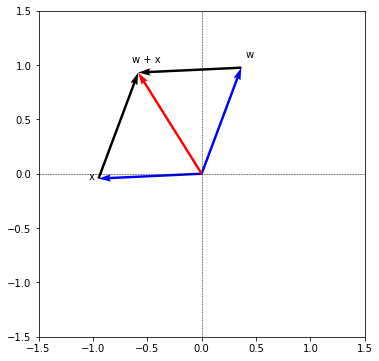

In [9]:
positive_misclassified_geometry()

An analogous argument applies to misclassified _negative instances_ for which ${\bf w} \cdot {\bf x} > 0$ and thus the angle between ${\bf w}$ and ${\bf x}$ is acute.  The weight vector after the update is ${\bf w} - {\bf x}$ and its angle with ${\bf x}$ is larger after the update than before.  That is, the update causes the weight vector to turn away from a misclassified negative instance and thus moves the separator closer to the instance.  The cell below shows that graphically, and can be run multiple times to see different configurations.

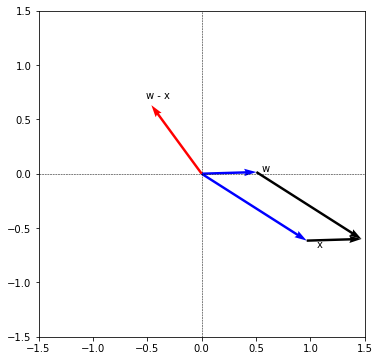

In [10]:
negative_misclassified_geometry()

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

One way to make the geometry of Perceptron updates concrete is to imagine that your nose is the weight vector.  If you hold your arms straight out on each side, they form a line that represents the separating hyperplane.  As a classifier, you label every point in front of you  positive and every point behind you negative.  If a true negative point is in front of you, it is misclassified and the update subtracts its vector from the weight vector (your nose) turning your body away from it.  As your body turns away from the point, your arms move.  If you turn often enough or far enough, the point will wind up behind you where it belongs.  The same principle is at work for positive points that are misclassified, except they are behind you and cause your nose, body, and arms (still straight out at your sides) to turn toward them.  With enough turning, the misclassified positive point will be in front of you where it belongs. 

## 2.3 Running the Perceptron 

This section explores the behavior of the Perceptron Learning Algorithm on two datasets - the example dataset used earlier in this chapter, and the mushroom dataset from the first chapter.  Consider the cell below.  It copies the dataframe containing the example dataset and shuffles the order of the rows, runs the Perceptron Learning Algorithm to get the weight sequence, and passes the dataframe and weight sequence to the constructor for a class that animates the behavior of the algorithm.  That cell starts with `%%capture` to suppress any output because the final call to the `animate` function produces an extraneous plot.  

In [11]:
%%capture
ex = df.sample(frac = 1.)
weights = perceptron(ex)
anim = PerceptronAnim(ex, weights, trail = True)
afunc = anim.animate()

The next cell produces the on-screen animation.  It shows the instances in the two classes in the feature space colored by their class label.  The instance being considered in the inner loop of the algorithm is drawn with a large black dot.  As the inner loop runs, that dot will hop around randomly because the order of the instances in the dataframe was randomized.  Below the data plot is a set of video controls whose meanings should be obvious.  To start the animation, press the "play" button.  You'll see the current separator appear as a black line with a small black arrow pointing in the direction of the positive half-plane. Each time the classifier makes a mistake on a training instance, the separator moves, but the arrow remains to give some history of how the separator's location evolved through time.  To prevent the arrows from being drawn, change the value of the `trail` keyword in the cell above to `False`.

In [12]:
HTML(afunc.to_jshtml())

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

Run the code above a few times, starting with the cell that prepares the dataframe so that the order of the instances is different each time.  You'll notice that the hyperplane only moves when the current instance (marked by the black dot) is on the wrong side.  Though the learning algorithm is deterministic, the final hyperplane depends on the order of the instances in the dataframe.  In particular, sometimes the hyperplane stops changing when it is very close to the red circles and very far away from the green plusses.  We'll see in later chapters that this is undesirable and explore methods that produce hyperplanes that are "safer" and do so irrespective of the order of the instances.

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

The cell below prepares the mushroom dataset from the first chapter for the Perceptron Learning Algorithm.  It converts the class labels so that ${\tt poisonous}$ maps to ${\tt +1}$ and ${\tt edible}$ maps to ${\tt -1}$, inserts a columns of ${\tt 1}$'s to serve as the bias term, and shows the first two rows of the dataframe.

In [13]:
training_set = json.loads(open('chapter_1_mushroom_dataset.json').read())
mushrooms = pd.DataFrame(training_set)
mushrooms = mushrooms[['color', 'width', 'height', 'label']]
mushrooms['label'] = mushrooms.apply(lambda row: 1 if row['label'] == 'poisonous' else -1, axis = 1)
mushrooms.insert(0, 'bias', 1)
mushrooms.head(2)


,bias,color,width,height,label
0,1,-0.311688,0.358501,0.936567,-1
1,1,-0.472327,0.817906,0.468387,1


The next cell runs the learning algorithm and gets the final weight vector.  Recall that the `perceptron` function returns a generator object.  The final weight vector is obtained by turning that object into a list and getting the value at index ${\tt -1}$.  Note that the bias weight is 0, which means that the learned hyperplane passes through the origin.  The weight on the ${\tt color}$ attribute is small, but not 0, which means that it has some effect on predicted class labels, but much less so than the weights on the ${\tt width}$ and ${\tt height}$ attributes which are about 3 times larger in magnitude.  That's good because the color attribute is irrelevant to the class label.  Recall from the discussion above in which we hand-coded weights for this dataset that a positive weight on ${\tt width}$ and a roughly equivalent negative weight on ${\tt height}$ would lead to accurate predictions.  Indeed, that's what the algorithm has discovered.

In [32]:
weights = list(perceptron(mushrooms, label = 'label', bias = False))[-1]
weights

bias      0.000000
color    -0.160639
width     0.459405
height   -0.468180
Name: 0, dtype: float64

We can check the weights to see if they classify the two instances shown above correctly by computing the dot product of the weight vector and the feature values.  That dot product should be less than 0 for the first instance and greater than zero for the second instance.  As expected, they are classified correctly as can be seen in the cell below.  It computes ${\bf w} \cdot {\bf x}$ for an instance whose index in the dataframe in specified by the value of `index`.

In [15]:
for index in range(2):
    print('w.x for instance %d = %.2f' % (index, np.dot(weights, mushrooms.iloc[index][weights.index].values)))

w.x for instance 0 = -0.22
w.x for instance 1 = 0.23


## 2.4 Deriving the Perceptron Learning Algorithm from First Principles

Although the operation of the Perceptron Learning Algorithm makes sense, the discussion above was post hoc.  Given the algorithm, we sought to explain its behavior.  But where did the algorithm come from in the first place?  This section introduces a number of key concepts related to specifying what we want a machine learning algorithm to accomplish, and describes an approach to deriving the algorithm given that specification.  In the course of the discussion, we'll apply that approach to derive the Perceptron algorithm.

The idea is to write down a **loss function** that specifies how bad it is for the classifier to make mistakes and then cast learning as an optimization problem where the goal, in the case of the Perceptron, is to find a weight vector that minimizes the loss on the training data.  An example of a loss function is the 0-1 loss, shown in tabular form below.

|   $L_{0-1}$  | $\hat y = -1$ | $\hat y = 1$
| ----------- | ----------- | ----- |
| $y = -1$ | 0 | 1 |
| $y = 1$ | 1 | 0 |

For each of the four possible combinations of true ($y$) and predicted ($\hat y$) labels for a given instance, the table shows how much much loss is incurred.  It's called the 0-1 loss because the loss is 0 when the classifier is correct (i.e., $y = \hat y$) and the loss is 1 when the classifier is wrong ($y \neq \hat y$).  The sum of $L_{0-1}$ over a training set is just the number of misclassified instances, which we want to minimize.

The 0-1 loss is a function of two things, the true and predicted class labels, which can be written $L_{0-1}(y, \hat y)$.  For the Perceptron, $\hat y$ is a function of ${\bf w}$ and ${\bf x}$, so we can write the 0-1 loss as follows:

$$
L_{0-1}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
1 & \text{otherwise}
\end{cases}
$$

If the signs of $y$ and ${\bf w} \cdot {\bf x}$ are the same, the instance is classified correctly and there is no loss, otherwise the loss is 1.  Because the $({\bf x}, y)$ pairs in the training set are given as input and fixed, the only way to change the loss is to modify ${\bf w}$.  This reduces the learning problem to finding a weight vector that minimizes the loss given the training data.

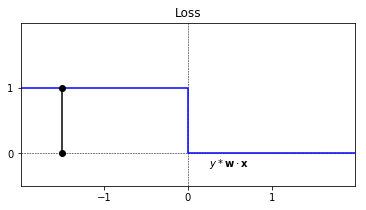

In [16]:
perceptron_loss_plot(ywx = -1.5)

$L_{0-1}$ is plotted above as a function of $y * {\bf w} \cdot {\bf x}$.  The plot also shows the location of an instance for which $y * {\bf w} \cdot {\bf x} = -1.5$ and the associated loss.  You and I can look at the plot and think "clearly there is lower loss to the right of that point, so the algorithm just needs to modify the weight vector so that $y * {\bf w} \cdot {\bf x}$ increases".  But the learning algorithm does not have that global view of the loss surface.  To explore the loss for new weight vectors requires an evaluation of $L_{0-1}(y, {\bf w} \cdot {\bf x})$, and there are infinitely many possible weight vectors.  The plot below gives you some idea of what it is like to be a Perceptron with the 0-1 loss function and a misclassified instance.  You can compute the loss given the current weight vector and for weight vectors that are close to the current one, but they all look equally bad with a loss of 1.

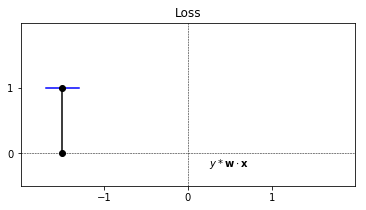

In [17]:
perceptron_loss_plot(ywx = -1.5, window = True)

The loss function needs to convey more information about how to modify the weights to reduce the loss.  The loss function plotted below, which we'll call the Perceptron loss and denote $L_p$, does just that.  It can be written as follows:

$$
L_{P}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
-y * {\bf w} \cdot {\bf x} & \text{otherwise}
\end{cases}
$$

There is still 0 loss for correctly classified instances, but the loss for incorrectly classified instances is $-y * {\bf w} \cdot {\bf x}$.  Why?  First, note that $-y * {\bf w} \cdot {\bf x} > 0$ for misclassified instances, so the loss is a positive number.  Suppose the misclassified instance is negative.  Because it is misclassified, it sits in the positive half-plane defined by the weight vector.  Recall that the weight vector points in the direction of the positive half-plane.  Because ${\bf w} \cdot {\bf x}$ is proportional to the cosine of the angle between ${\bf w}$ and ${\bf x}$, as that angle gets smaller, ${\bf x}$ rotates to be more aligned with $w$ and further away from the separating hyperplane, and ${\bf w} \cdot {\bf x}$ gets larger.  Therefore, the larger the value of $-y * {\bf w} \cdot {\bf x}$ for a negative instance that is misclassified, the further it is from the right side of the  hyperplane. Similar reasoning leads to the same conclusion for positive instances that are misclassified.  The $L_P$ loss is thus proportional to the distance of the instance from the hyperplane and assigns more loss to instances for which the current weight vector is "more wrong".

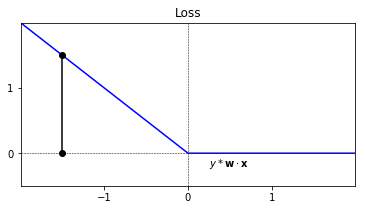

In [18]:
perceptron_loss_plot(ywx = -1.5, hinge = True)

The nice thing about the $L_P$ loss from a learning or optimization standpoint is that it provides useful information about how to modify the weights to reduce the loss.  The plot below again puts you in the shoes of a learning algorithm that has to figure out how to reduce the loss for a misclassified instance.  Now it's clear that "moving to the right" will reduce the loss using just local information.

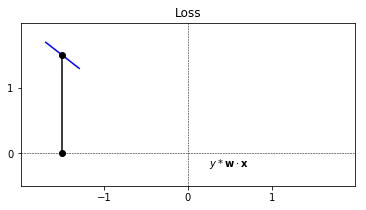

In [19]:
perceptron_loss_plot(ywx = -1.5, hinge = True, window = True)

The last piece of the puzzle is an automated way to compute weight updates that reduce the loss.  In this case, and many others we'll come across, that means using **gradient descent**, which is an iterative optimization algorithm.  We'll introduce the main concepts by way of a simple example and then apply gradient descent to derive the Perceptron update rule.

Suppose you're given the function $f(w) = (w - 4)^2 + 1$ and asked to find the value of $w$ that minimizes $f$.  Think of $f$ as a loss function and $w$ as a weight.  The goal is to find the weight that minimizes the loss.  Ignore for the moment that there is a simple analytical solution to this problem.  That is typically not the case for loss functions used in machine learning.  Gradient descent requires the function to be differentiable, which this one is with $f'(x) = 2(w - 4)$, and an initial value for $w$, which is often chosen at random.  In this case, we'll use $w = 2.5$ as the initial guess.  The animation below shows this situation, with the function plotted in blue and the current value of $w$ and $f(w)$ shown with a black line from $(w, 0)$ to $(w, f(w))$.  You'll notice that the tangent to $f(w)$ is shown as well, which is crucial to the operation of the algorithm.

In [20]:
%%capture 
anim = GradientDescentAnim(lambda w: (w - 4)**2 + 1, [2, 6], 2.5)
anim.step_size = 0.05
afunc = anim.animate()

In [21]:
HTML(afunc.to_jshtml())

The slope of the tangent line in the first frame of the animation is $f'(2.5) = 2(2.5 - 4) = -3$.  This linear or first-order approximation to the function at $w = 2.5$ suggests that increasing $w$ will cause $f(w)$ to decrease because the slope of the tangent line is negative.  That is, for small values of $\epsilon > 0$, we expect $f(2.5 + \epsilon) < f(2.5)$.  In contrast, if the initial guess for $w$ had been 5, the slope of the tangent line would be $f'(5) = 2(5 - 4) = 2$.  Because the slope of the tangent line at $w = 5$ is positive, decreasing $w$ will cause $f(w)$ to decrease and we expect $f(5 - \epsilon) < f(5)$.  In both cases, given the current value of $w$, adjusting $w$ by an amount that has the negative of the sign of $f'(w)$ leads to a smaller value of $f$.

In this simple case, gradient descent updates the weight using the following rule:

$$ w = w - \alpha * f'(w) $$

The new weight is just the old weight minus a constant multiple of the slope of the tangent line of the function at the old weight.  The constant multiple is called the **step size** or **learning rate**, and $\alpha \in (0, 1]$.  The steeper the tangent, the larger the value of $|f'(w)|$ and the larger the change in $w$.  Because the upate subtracts $\alpha f'(w)$, the change in $w$ has the opposite sign of the slope of the tangent, which we saw above leads to reducing $f(w)$ after the update.

What is the role of $\alpha$?  Gradient descent approximates the function at a point with a straight line.  Unless the function is in fact linear, the approximation gets increasingly less accurate the further you move from that point.  For larger values of $\alpha$, you take a larger step and can wind up at a point where the function has increased rather than decreased.

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

If you haven't already done so, run the animation above.  You'll notice that $w$ moves from 2.5 toward 4, which is the value that minimizes the function.  It moves more quickly early on because the slope is larger.  The closer $w$ gets to the value the minimizes $f$, the smaller the slope of the tangent line and the smaller the update to $w$.  Now change the step size to 1.  What happens?  The weight oscillates between two values and never makes progress.  The first weight update is as follows:
$$
\begin{eqnarray}
w & = & w - \alpha * f'(w) \\
 & = & w - \alpha * 2 * (w - 4) \\
 & = & 2.5 - 1 * 2 * (2.5 - 4) \\
 & = & 5.5
\end{eqnarray}
$$
The next weight update is:
$$
\begin{eqnarray}
w & = & w - \alpha * f'(w) \\
 & = & w - \alpha * 2 * (w - 4) \\
 & = & 5.5 - 1 * 2 * (5.5 - 4) \\
 & = & 2.5
\end{eqnarray}
$$
And we're right back where we started.  The step was so large that it hopped right over the minimum to the other side of the parabola where the slope has the same magnitude but opposite sign.  This is precisely the kind of kind of behavior that can occur when $\alpha$ is too large, but it can get worse.  What happens if $\alpha > 1$ in the example above?  The value of $w$ takes larger and larger steps on each iteration, hopping back and forth over the minimum point and getting farther and farther away from it.  Eventually, the weights will get so large that the code will throw a floating point overflow exception.

Finally, try running gradient descent in the cells below.  What happens?  The function $f(w) = \cos(w) + w/2$ has several valleys, but no two valleys have the same minimum height.  Given the starting point, gradient descent moves in the right direction (downhill) but settles into a **local minimum**, a point where the slope of the tangent line is 0 that is not where the function takes on its smallest value.  Gradient descent is not guaranteed to find a **global minimum**, but if the step size is small enough it will find a local minimum.  There will be more to say about this is later chapters.

In [22]:
%%capture 
anim = GradientDescentAnim(lambda w: math.cos(w) + w/2, [0, 4 * math.pi], 3.75 * math.pi)
anim.step_size = 0.15
afunc = anim.animate()

In [23]:
HTML(afunc.to_jshtml())

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

We're finally ready to use gradient descent to derive the update rule for the Perceptron.  There are just two more details to work out, both of which are seen in the plot below.  The `perceptron_loss_plot_3d` function takes as input a vector of the form ${\bf x} = [x_1,x_2]$ and a class label $y$, and plots the $L_P$ loss as a function of ${\bf w} = [w_1, w_2]$.

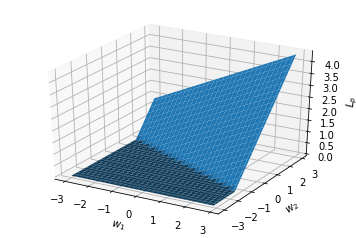

In [24]:
perceptron_loss_plot_3d([-0.5, -1], 1)

The first detail to work out is that the Perceptron maintains a weight vector, not just a single weight as in the examples above, and every element of that vector needs to be updated.  For each of the weights we want to know whether it should be increased or decreased, and by how much, to reduce the loss.  In the plot above, we need to compute updates for $w_1$ and $w_2$ given the current training instance, i.e., $({\bf x}, y)$.  That requires the use of the partial derivative of the loss with respect to each of the weights.  For example, the update rule for the $i^{th}$ weight, $w_i$, would be:

$$
w_i = w_i - \alpha \frac{\partial L_P}{\partial {w_i}}
$$

That is, we ask how $L_P$ changes as a function of $w_i$ if we hold all of the other weights constant and perform the standard update.  The **gradient** of a multi-variate function is just a vector of all of the partial derivatives with respect to each of the variables.  The gradient of the Perceptron loss is:

$$ 
\nabla L_P = \left(
\frac{\partial L_P}{\partial {w_0}},
\frac{\partial L_P}{\partial {w_1}}, \ldots, 
\frac{\partial L_P}{\partial {w_n}}
\right)
$$

The resulting vector-valued Perceptron update becomes:

$$
{\bf w} = {\bf w} - \alpha \nabla L_P
$$

The new weight vector is just the old weight vector minus a constant multiple of the slope of the tangent plane of the function at the old weight vector.

Recall that $L_P$ is:

$$
L_{P}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
-y * {\bf w} \cdot {\bf x} & \text{otherwise} 
\end{cases} 
$$

When $y * {\bf w} \cdot {\bf x} > 0$, the instance is classified correctly and $L_P$ is a constant (0) with zero slope in all directions so the gradient is:

$$
\nabla L_P = (0, 0, \ldots, 0)
$$

Using the vector valued update ${\bf w} = {\bf w} - \alpha \nabla L_P = {\bf w} - \alpha * (0, \ldots, 0) = {\bf w}$ results in no change to the weight vector when the instance is classified correctly.

When $y * {\bf w} \cdot {\bf x} \leq 0$, the instance is classified incorrectly so we need to compute the partial derivatives of $L_P$ with respect to each of the weights:

$$
\frac{\partial L_P}{\partial {w_i}} = 
\frac{\partial}{\partial {w_i}} \left(-y \sum_j w_j x_j \right) =
-y x_i
$$


Therefore, when the instance is misclassified the gradient is:

$$
\nabla L_P = (-y x_0, -y x_1, \ldots, -y x_n) = -y {\bf x}
$$

The vector valued update ${\bf w} = {\bf w} - \alpha \nabla L_P$ becomes ${\bf w} = {\bf w} + \alpha y {\bf x}$.  Setting $\alpha = 1$ gives precisely the Perceptron update!  For positive instances, ${\bf x}$ is added to the weight vector, and for negative instances, ${\bf x}$ is subtracted from the weight vector.

The final detail to work out is how to handle the fact that $L_P$ is not differentiable.  There is a discontinuity at ${\bf w} \cdot {\bf x} = 0$ that we've conveniently ignored up to this point.  That discontinuity is clearly visible in the plot above where the sloped plane where the instance is classified incorrectly meets the region in weight space where the instance is classified correctly (i.e., where $L_P = 0$).  There are infinitely many tangent planes that contain the line ${\bf w} \cdot {\bf x} = 0$, or in the plot above $-0.5 w_1 - w_2 = 0$.  Fortunately, the theory of subgradients says that we can choose any tangent plane that lower bounds $L_P$ and use its slope as the gradient in gradient descent.  One such plane is $L_P = 0$, which contains the half-plane where the classifier is correct for the instance.  Another such plane is $L_P = -y * {\bf w} \cdot {\bf x}$, which contains the half plane where the classifier is incorrect for the instance.  Choosing the latter subgradient at the point of discontinuity (i.e., where ${\bf w} \cdot {\bf x} = 0$) means that the vector valued update rule is precisely the update rule as originally presented in the algorithm above.

## Linear Separability and Convergence

The Perceptron Learning Algorithm is guaranteed to converge, or terminate in a finite number of steps, if the data are **linearly separable**.  Intuitively, in two dimensions that means that there exists a line in the feature space such that all instances from one class are on one side of the line and all instances from the other class are on the other side of the line.  In three or more dimensions, linear separability means that there exists a plane or hyperplane such that all instances from one class are on one side of the (hyper)plane and all instances from the other class are on the other side of the (hyper)plane.

What happens if the data are not linearly separable?  The cell below shows the algorithm running on a dataset (the exclusive-or function) that is not linearly separable.  There are four instances, two of each class, arranged on the corners of a square.  Instances of the same class are diagonally opposite each other.  There is no line that perfectly separates the two classes, even though there are only four instances.  Run the animation and you'll see that the weight vector gets caught in a cycle where each update adjusts the weight vector so that the current instance is classified correctly, but doing so causes an instance previously classified correctly to be misclassified by the new weight vector.  Sometimes the separator will disappear, which happens when it becomes a zero vector  or lies completely outside of the region occupied by the data.  The Perceptron will run forever if the data are not linearly separable, thus the use of an argument to the learning algorithm that limits the number of epochs - just in case.

In [25]:
%%capture
xor = pd.DataFrame({'x1': [-1, 1, -1, 1],
                    'x2': [-1, -1, 1, 1],
                    'y': [-1, 1, 1, -1]})
xor = xor.sample(frac = 1.)
weights = perceptron(xor, epochs = 5)
anim = PerceptronAnim(xor, weights, trail = True)
afunc = anim.animate()

In [26]:
HTML(afunc.to_jshtml())

Proving that the algorithm converges for linearly separable data requires a precise definition of linear separability.  For the Perceptron, we will say that a dataset is linearly separable if for all instances $({\bf x}, y)$ there exists a weight vector ${\bf w}$ and a real number $\gamma > 0$ such that $y * {\bf w} \cdot {\bf x} \geq \gamma$.  Note that this is slightly different from saying that the weight vector correctly classifies all of the instances.  That simply requires that $y * {\bf w} \cdot {\bf x} > 0$.  After proving convergence we'll use $\gamma$ to explore how easy or hard a dataset is for the learning algorithm.

**Theorem 1:** Given a dataset containing instances $({\bf x_i}, y_i)$, assume that (1) there exists ${\bf w^*}$ and $\gamma > 0$ such that $y_i * {\bf w^*} \cdot {\bf x_i} \geq \gamma$, and that (2) $||{\bf x_i}||_2 \leq R$.  Then the perceptron make a number of mistakes/updates during learning that is at most $(R ||{\bf w^*}||_2/\gamma)^2$.

**Proof:** The first assumption is that the data are linearly separable.  The second is that the length of the attribute vectors has an upper bound.  We'll start by showing that the dot product between the weight vector being learned and a weight vector that perfectly classifies the data gets larger on every update.

Let ${\bf w^k}$ be the weight vector after the update for the $k^{th}$ mistake, so ${\bf w^0} = (0, \ldots, 0)$.  Suppose the $k^{th}$ mistake is made on instance $({\bf x}, y)$.  Then:

$$
\begin{eqnarray}
{\bf w^*} \cdot {\bf w^{k}} 
& = & {\bf w^*} \cdot ({\bf w^{k - 1}} + y * {\bf x}) \\
& = & {\bf w^*} \cdot {\bf w^{k - 1}} + y * {\bf w^*} \cdot {\bf x} \\
& \geq & {\bf w^*} \cdot {\bf w^{k - 1}} + \gamma
\end{eqnarray}
$$

The first line follows from the fact that an error was made so ${\bf w^k}$ is obtained from ${\bf w^{k-1}}$ by adding $y * {\bf x}$.  The second line distributes ${\bf w^*}$, and the third follows from the assumption that $y_i * {\bf w^*} \cdot {\bf x_i} \geq \gamma$.

It's easy to see by induction on $k$ that ${\bf w^*} \cdot {\bf w^k} \geq k\gamma$.  That is, every time a mistake is made and the weight vector is updated, ${\bf w^*} \cdot {\bf w}$ grows by at least $\gamma$.  Intuitively, that means that ${\bf w}$ is getting larger, or it is rotating to be more aligned with ${\bf w^*}$, or both.

Next we'll find an upper bound on the magnitude of ${\bf w^k}$ so that we can use the result above to lower bound the degree of alignment between ${\bf w^k}$ and ${\bf w^*}$ as $k$ grows.

$$
\begin{eqnarray}
||{\bf w^k}||_2^2 & = & ||{\bf w^{k - 1}} + y * {\bf x}||_2^2 \\ 
& = & ||{\bf w^{k - 1}}||^2_2 + 2 y * {\bf w^{k-1}} \cdot {\bf x} + ||{\bf x}||_2^2 \\
& \leq & ||{\bf w^{k - 1}}||^2_2 + R^2
\end{eqnarray}
$$

The first line follows from the fact that an error was made so ${\bf w^k}$ is obtained from ${\bf w^{k-1}}$ by adding $y * {\bf x}$. The second line expands the quadratic term in the first line.  The inequality in the third line follows from the fact that a mistake was made so $y * {\bf w^{k-1}} \cdot {\bf x}$ is negative, and by the assumption that $||{\bf x}||_2 \leq R$.

Again, by induction on $k$, it's easy to see that $||{\bf w^k}||_2^2 \leq k R^2$.  This makes intuitive sense because the length of the longest vector in the training set is $R$ and each mistake adds one of those vectors to ${\bf w}$.

Finally, note that the cosine of the angle between ${\bf w^*}$ and ${\bf w^k}$ is:

$$
\begin{eqnarray}
\cos({\bf w^*}, {\bf w^k}) & = & \frac{{\bf w^*} \cdot {\bf w^k}}{||{\bf w^*}||_2 ||{\bf w^k}||_2} \\
1 & \geq & \frac{k \gamma}{||{\bf w^*}||_2 \sqrt{k R^2}} \\
k & \leq & \frac{R^2 ||{\bf w^*}||_2^2}{\gamma^2}
\end{eqnarray}
$$

The first line is just the definition of the cosine of the angle between two vectors.  The second line makes several substitutions with upper and lower bounds.  On the left-hand side, 1 is an upper bound on the cosine.  In the right-hand side numerator, $k \gamma$ is our lower bound on ${\bf w^*} \cdot {\bf w^k}$.  In the right-hand side denominator, $\sqrt{k R^2}$ is our upper bound on $||{\bf w^k}||_2$.  These substitutions ensure that the $\leq$ inequality holds in the second line.  The final line just solves the second one for $k$.  The cosine of the angle between ${\bf w}$ and ${\bf w^*}$ increases with each mistake, and it can only increase so often until it hits the upper limit of 1.
<font size="5">&#8718;</font>

What does this result mean?  The most interesting quantity is $\gamma$, which is related to the **margin** of the classifier.  The margin is the smallest distance from the hyperplane to any ${\bf x}$ in the training set.  The plot below shows a 2-class dataset and a linear separator with what feels like a "large" margin.  There is plenty of space between the separator and the closest points.  If either the line or any of the instances move a bit, perhaps to adjust for newly discovered measurement noise in the feature values, the classifier would probably still be 100% accurate on the training data.

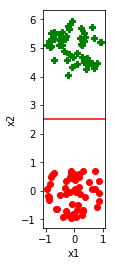

In [27]:
plot_2d(uniform_circle_dataset([(0, 0), (0, 5)], [1, 1], 50),
        weights = (-2.5, 0, 1), show_separator = True)

The situation is very different for the dataset below.  There is very little space between the instances belonging to the two classes, and the separator is much more tightly constrained.  If either it or any of the instances move around, even by a small amount, it's easy to imagine that the classifier would no longer perfectly separate the data.  That's what a "small" margin looks like.

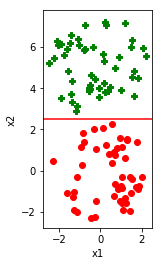

In [28]:
plot_2d(uniform_circle_dataset([(0, 0), (0, 5)], [2.5, 2.5], 50),
        weights = (-2.5, 0, 1), show_separator = True)

We can make the relationship between $\gamma$ and the margin precise, and thereby understand the role that $\gamma$ plays in the Perceptron's mistake bound.  Suppose $({\bf x}, y)$ is a training instance for which $y * {\bf w^*} \cdot {\bf x} = \gamma$.  That is, ${\bf x}$ is the closest point to the hyperplane when learning is done.  There can be other points that are the same distance as ${\bf x}$ from the hyperplane, but none can be closer.  There exists some point, ${\bf x^0}$, that sits on the hyperplane such that ${\bf x} = {\bf x^0} + y \lambda {\bf w^*}$ for some $\lambda > 0$.  That is, we can get to ${\bf x}$ by starting somewhere on the hyperplane and moving perpendicular to it some distance in the direction of ${\bf w^*}$ for positive instances ($y = {\tt +1}$) and in the opposite direction of ${\bf w^*}$ for negative instances ($y = {\tt -1})$.  The margin is $\lambda ||{\bf w^*}||_2$ because that's the magnitude of the vector travelled to get from the hyperplane to ${\bf x}$, which is the closest point.  Therefore:

$$
\begin{eqnarray}
y * {\bf w^*} \cdot {\bf x} & = & y * {\bf w^*} \cdot ({\bf x^0} + y \lambda {\bf w^*}) \\
& = & y * {\bf w^*} \cdot {\bf x^0} + y^2 \lambda ||{\bf w^*}||_2^2 \\
\gamma & = & \lambda ||{\bf w^*}||_2^2 \\
\frac{\gamma}{||{\bf w^*}||_2} & = & \lambda ||{\bf w^*}||_2
\end{eqnarray}
$$

The first line expands ${\bf x}$.  The second line distributes the dot product.  The third line follows because ${\bf w^*} \cdot {\bf x^0} = 0$ and $y^2 = 1$ regardless of the value of $y$.  To get to the fourth line we divide both sides by $||{\bf w^*}||_2$.  For a given ${\bf w^*}$ that linearly separates the data (as specified in Theorem 1), $\gamma/{||{\bf w^*}||_2}$ is the value of the margin.

The mistake bound (see Theorem 1 above) is $R^2 ||{\bf w^*}||_2^2 / \gamma^2$, and is thus inversely proportional to the square of the margin.  That is, as the margin gets smaller the learning problem gets harder and we expect the Perceptron to make more mistakes before converging.  But as the margin gets larger the learning problem gets easier and we expect the Perceptron to make fewer mistakes before converging.  

## The Multi-Class Perceptron

Up to this point we've dealt exclusively with binary classification problems where there are only two class labels - poisonous or edible, creditworthy or too risky, spam or valid email.  However, many real-world problems involve more than two options.  Sentiment classification applied to the text of movie or product reviews determines if a review is positive, negative, or neutral.  Part-of-speech taggers learn to assign one of eight parts of speech to each word in a sentence - noun, pronoun, verb, adjective, adverb, preposition, conjunction, or interjection.  And speech recognition systems can be trained to classify a sound according to which of the 44 English phonemes it corresponds. 

A few small changes to the Perceptron Learning Algorithm allow it to handle **multi-class classification** problems, like the one shown below.  There are many ways of dealing with multi-class problems, but the one used by the Perceptron is called "one vs. all" or "one vs. rest".  The idea is to treat a problem with $k$ classes as $k$ binary classification problems.  For the dataset below, there are $k = 3$ classes and the multi-class Perceptron will learn 3 linear separators simultaneously.  One of them will separate the blue stars from the red circles and green plusses.  Another will separate the red circles from the blue stars and green plusses, and the last one will separate the green plusses from the red circles and blue stars.  Each hyperplane tries to separate "one" class from the "rest" of the classes.

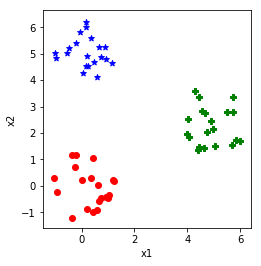

In [29]:
mc = pd.read_json('multiclass_perceptron.json')
plot_2d(mc)

The multi-class Perceptron algorithm is shown below, and it looks a lot like the binary Perceptron algorithm introduced earlier in this chapter.    We'll focus on the differences.  The first is that line ${\bf 7}$ initializes a weight vector of all 0's per unique class label in the dataset. (Recall that you can add line numbers to a code cell by clicking on it and typing ${\tt ESC}$ followed by ${\tt L}$.)  The implementation stores the weight vectors in a dictionary keyed by class label.  We'll denote the weight vector associated with class $c$ by ${\bf w_c}$.  Lines ${\bf 16 - 18}$ are one logical line of code, and get the prediction of the Perceptron, $\hat y$, as the class $c$ for which ${\bf w_c} \cdot {\bf x}$ is the largest.  Ties are broken randomly.

Recall that ${\bf w} \cdot {\bf x}$ is proportional to the distance of ${\bf x}$ from the hyperplane defined by ${\bf w}$.  Choosing to predict the class $c$ that maximizes ${\bf w_c} \cdot {\bf x}$ corresponds to picking the binary classifier that is most "certain" about ${\bf x}$.  If all of the dot products are negative, the chosen class will be the one for which ${\bf x}$ is closest to the positive side of the hyperplane.  If just one dot product is positive, that class will be chosen.  If more than one dot product is positive, the chosen class will be the one for which ${\bf x}$ is deepest into its positive half-plane.

All that's left is to understand the update.  Line ${\bf 20}$ asks if the predicted class label is correct.  If it is, the algorithm moves on to the next instance.  Otherwise, the weights are updated in lines ${\bf 21}$ and ${\bf 22}$.  Line ${\bf 21}$ updates the weight vector of the incorrectly predicted class by subtracting ${\bf x}$.  As discussed above, subtracting ${\bf x}$ makes the weight vector "turn away" from ${\bf x}$ in an effort to get it into the negative half-plane.  Line ${\bf 22}$ updates the  vector of the true class by adding ${\bf x}$, which makes that weight vector "turn toward" ${\bf x}$ in an effort to get it into the positive half-plane.  That's it!

In [30]:
def multiclass_perceptron(df, label = 'y', epochs = 100, bias = True):
    
    if bias:
        df = df.copy()
        df.insert(0, '_x0_', 1)
      
    w = {c:np.zeros(len(df.columns) - 1) for c in df[label].unique()}   
    features = [column for column in df.columns if column != label]

    for _ in range(epochs):
        errors = 0
        for _, row in df.iterrows():
            x = row[features]
            y = row[label]
            
            yhat = sorted(w.keys(), 
                          key = lambda c: np.dot(w[c], x), 
                          reverse = True)[0]
            
            if y != yhat:
                w[yhat] -= x
                w[y] += x
                errors += 1
            yield w.copy()
        if errors == 0:
            break

A few other differences are worth discussing.  First, note that the class labels do not appear in the updates.  The binary Perceptron used the fact that the class labels are in $\{{\tt +1}, {\tt -1}\}$ so that the update ${\bf w} = {\bf w} + y * {\bf x}$ turns ${\bf w}$ toward misclassified positive instances and away from misclassified negative instances.  The multi-class Perceptron breaks that single update into two parts when a mistake is made - one for the true class label and one for the incorrectly predicted class label.

Second, it may seem odd that for $k = 2$ classes we need one weight vector, but for $k = 3$ classes we need three weight vectors.  What happened to two weight vectors?  For the binary Perceptron, if a point is on the positive side of the hyperplane it is not on the negative side.  And if a point is on the negative side on the hyperplane it is not on the positive side.  However, as you can see in the plot below, the situation is more complicated for the multi-class Perceptron.  The plot shows the 3-class dataset above, with the final learned separators.  All of the blue stars are on the positive side of the blue hyperplane, all of the green plusses are on the positive side of the green hyperplane, and all of the red circles are on the positive side of the red hyperplane.

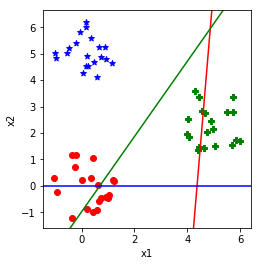

In [31]:
plot_2d(mc, weights = list(multiclass_perceptron(mc))[0], show_separator = True)

But just because a point is on the positive side of a particular hyperplane does not mean that it belongs to the corresponding class.  For example, there are red circles on the positive side of the blue hyperplane.  However, those seemingly misplaced red circles are farther from the red hyperplane than they are from the blue hyperplane and will thus be classified correctly.  Remember, a point is assigned to the class $c$ for which ${\bf w_c} \cdot {\bf x}$ is maximized.  In fact, there are red circles that are on the positive side of all three hyperplanes, but they are all farthest from the red hyperplane.  Because you cannot rule a point in or out for a class by checking a single hyperplane like you can in the binary case, you need $k$ hyperplanes for $k > 2$ classes.

## Final Thoughts

---

To do:
* Talk about the role of R in the mistake bound